# Time-to-Detection (TTD) Optimization for Antibiotic Susceptibility Testing

**Author:** Rafael Proença  
**Course:** 1MD048 Research Methodology, Uppsala University  
**Date:** December 2025

---

## Overview

This notebook implements a pipeline to optimize Time-to-Detection (TTD) of antibiotic treatment effects in *Mycobacterium smegmatis* using pre-computed Omnipose segmentation masks. The pipeline compares control (REF) versus rifampicin-treated (RIF) conditions to identify the earliest reliable detection of growth inhibition.

## Data Required

The segmentation mask data is available through **Studium** (course materials). Download and extract with this structure:
```
data/
├── Original_data/           # Susceptible strain dataset
│   ├── REF_raw_data.../     # Control masks
│   │   └── Pos101/MASK_*.tif
│   └── RIF_raw_data.../     # Rifampicin-treated masks
│       └── Pos101/MASK_*.tif
└── HR/                      # Heteroresistant strain dataset
    ├── HR_REF_masks/
    └── HR_RIF10_masks/
```

## Requirements

```bash
pip install numpy pandas matplotlib scikit-image scipy natsort
```

## Instructions

1. Install requirements (see above)
2. Download data from Studium and extract to a `data/` folder next to this notebook
3. Update `DATA_ROOT` in Cell 2 if your data is in a different location
4. Run all cells in order (Kernel → Restart & Run All)
5. Change `DATASET_INDEX` in Cell 6 to switch datasets (0=Susceptible, 1=HR)

## Methods

Four TTD detection methods are implemented and compared:
1. **Relative Difference** — Detects when (REF-RIF)/REF exceeds a threshold
2. **Slope Change** — Detects divergence in growth rates
3. **Statistical (t-test)** — Detects significant difference between conditions
4. **Ratio Threshold** — Detects when RIF/REF ratio drops below threshold


In [11]:
# =============================================================================
# MASTER SETUP: IMPORTS, FUNCTIONS & PATH CONFIGURATION  
# =============================================================================
import os
import sys
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from scipy import stats
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from scipy.stats import variation, skew, kurtosis, ttest_ind, mannwhitneyu, norm
from natsort import natsorted

# --- HELPER FUNCTIONS ---

def find_all_masks(base_path, dataset_mode='susceptible'):
    """
    Recursively find all mask files in the dataset.
    Returns dict: {'REF': [...], 'RIF': [...]}
    """
    results = {'REF': [], 'RIF': []}
    
    # Search patterns for mask files
    patterns = ['**/MASK*.tif', '**/mask*.tif', '**/MASK*.png', '**/*_masks*.tif', '**/*.tif']
    
    all_masks = []
    for pattern in patterns:
        found = glob.glob(os.path.join(base_path, pattern), recursive=True)
        all_masks.extend(found)
    
    # Remove duplicates and filter for actual mask files
    all_masks = list(set(all_masks))
    all_masks = [m for m in all_masks if 'mask' in m.lower() or 'MASK' in m]
    
    # Classify by condition (REF or RIF)
    for mask_path in all_masks:
        path_upper = mask_path.upper()
        
        # Check for RIF first (more specific patterns)
        if 'RIF' in path_upper and 'REF' not in path_upper:
            results['RIF'].append(mask_path)
        # Then check for REF
        elif 'REF' in path_upper:
            results['REF'].append(mask_path)
    
    # Sort naturally
    results['REF'] = natsorted(results['REF'])
    results['RIF'] = natsorted(results['RIF'])
    
    return results


def find_hr_masks(hr_path):
    """
    Special handler for HR dataset which may have different structure.
    """
    results = {'REF': [], 'RIF': []}
    
    # Check for HR_REF_masks and HR_RIF10_masks folders/files
    if not os.path.exists(hr_path):
        print(f"  ⚠️ Path not found: {hr_path}")
        return results
        
    for item in os.listdir(hr_path):
        item_path = os.path.join(hr_path, item)
        
        if os.path.isdir(item_path):
            # It's a folder - search inside
            patterns = ['**/*.tif', '**/*.png']
            for pattern in patterns:
                found = glob.glob(os.path.join(item_path, pattern), recursive=True)
                # Filter for mask files
                found = [f for f in found if 'mask' in f.lower()]
                if 'REF' in item.upper() and 'RIF' not in item.upper():
                    results['REF'].extend(found)
                elif 'RIF' in item.upper():
                    results['RIF'].extend(found)
        
        elif item.endswith(('.zip', '.tar', '.tar.gz', '.tar.bz2')):
            print(f"  ⚠️ Found archive: {item}")
            print(f"     Please extract this file first!")
    
    results['REF'] = natsorted(results['REF'])
    results['RIF'] = natsorted(results['RIF'])
    
    return results


def group_by_position(mask_files):
    """
    Group mask files by position (Pos101, Pos102, etc.)
    """
    positions = {}
    for path in mask_files:
        match = re.search(r'(Pos\d+)', path, re.IGNORECASE)
        if match:
            pos = match.group(1)
        else:
            # For HR data without Pos labels, use parent folder or file index
            parent = os.path.basename(os.path.dirname(path))
            if parent:
                pos = parent
            else:
                pos = 'unknown'
        
        if pos not in positions:
            positions[pos] = []
        positions[pos].append(path)
    
    # Sort files within each position
    for pos in positions:
        positions[pos] = natsorted(positions[pos])
    
    return positions


def process_condition(position_groups, label, interval_minutes, filter_pos=None):
    """Extract metrics (Area, Cell Count) from mask files for each position."""
    print(f"  Processing {label}...")
    dataset_metrics = []  # List of dicts, one per position
    
    for pos_name, files in position_groups.items():
        if filter_pos and pos_name not in filter_pos:
            continue
        
        # Calculate metrics for each frame in this position
        pos_data = {'total_area': [], 'n_cells': []}
        for f in files:
            try:
                img = io.imread(f)
                area = np.count_nonzero(img)
                n_cells = len(np.unique(img)) - 1  # -1 to exclude background (0)
                pos_data['total_area'].append(area)
                pos_data['n_cells'].append(max(0, n_cells))
            except Exception as e:
                pos_data['total_area'].append(np.nan)
                pos_data['n_cells'].append(np.nan)
        
        if len(pos_data['total_area']) > 0:
            dataset_metrics.append(pos_data)
    
    return dataset_metrics


def aggregate_positions(data_list, metric_name='total_area'):
    """Calculate Mean and Std Dev across all positions for a given metric."""
    if not data_list:
        return None, None, None, None
    
    # Extract the specific metric from each position
    metric_data = []
    for pos_data in data_list:
        if isinstance(pos_data, dict) and metric_name in pos_data:
            metric_data.append(pos_data[metric_name])
        elif isinstance(pos_data, (list, np.ndarray)):
            metric_data.append(pos_data)
    
    if not metric_data:
        return None, None, None, None
    
    # Find max length
    max_len = max(len(x) for x in metric_data)
    
    # Pad shorter sequences with NaN so we can stack them
    padded_data = []
    for x in metric_data:
        pad = np.full(max_len, np.nan)
        pad[:len(x)] = x
        padded_data.append(pad)
    
    arr = np.array(padded_data)
    
    # Calculate stats ignoring NaNs
    mean_curve = np.nanmean(arr, axis=0)
    std_curve = np.nanstd(arr, axis=0)
    times = np.arange(len(mean_curve)) * TIME_INTERVAL_MINUTES
    
    return times, mean_curve, std_curve, arr


print("✓ Imports and helper functions loaded successfully!")


✓ Imports and helper functions loaded successfully!


In [ ]:
# =============================================================================
# PATH CONFIGURATION - UPDATE THIS FOR YOUR SYSTEM
# =============================================================================

# Set DATA_ROOT to the folder containing your extracted mask data
# The default assumes a 'data' folder next to this notebook
DATA_ROOT = "./data"
# Example paths for different systems:
# Windows:  DATA_ROOT = r"C:\Users\YourName\Downloads\mask_data"
# macOS:    DATA_ROOT = "/Users/YourName/Downloads/mask_data"
# Linux:    DATA_ROOT = "/home/yourname/data/mask_data"

# Dataset directories (relative to DATA_ROOT)
SUSCEPTIBLE_DIR = os.path.join(DATA_ROOT, "Original_data")
HR_DIR = os.path.join(DATA_ROOT, "HR")

# Validate paths
print("Checking data paths...")
for name, path in [("Susceptible", SUSCEPTIBLE_DIR), ("HR", HR_DIR)]:
    if os.path.exists(path):
        print(f"  ✓ {name}: {path}")
    else:
        print(f"  ✗ {name}: NOT FOUND - {path}")
        print(f"    → Please update DATA_ROOT or check your folder structure")

DATASET_DIRS = [SUSCEPTIBLE_DIR, HR_DIR]
print(f"\nReady to process {len(DATASET_DIRS)} dataset(s)")


Checking data paths...
  ✓ Susceptible: C:\Users\Rafallex\Documents\Uppsala\year 1\Semester 1\period 2\Research Methodolgy\notebooks\data_notebooks\Original_data
  ✓ HR: C:\Users\Rafallex\Documents\Uppsala\year 1\Semester 1\period 2\Research Methodolgy\notebooks\data_notebooks\HR

Ready to process 2 dataset(s)


In [13]:
# =============================================================================
# CELL 4: Configuration Parameters
# =============================================================================
# ============ ADJUST THESE PARAMETERS ============

# Time interval between frames (in minutes)
# Check your experimental protocol for the correct value!
TIME_INTERVAL_MINUTES = 10

# Positions to analyze (None = use all available)
POSITIONS_TO_USE = None  # or e.g., ['Pos101', 'Pos102']

# TTD Detection Methods to compare
TTD_METHODS = [
    'relative_difference',   # Simple relative difference threshold
    'slope_change',          # Change in growth slope
    'statistical',           # Statistical significance (t-test)
    'ratio_threshold',       # Ratio-based detection
]

# TTD Optimization Parameters (we'll search over these)
TTD_PARAM_GRID = {
    'rel_diff_thresholds': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],  # 5% to 30%
    'window_sizes': [3, 5, 7, 10],  # frames
    'p_value_thresholds': [0.05, 0.01, 0.001],
    'consecutive_frames': [2, 3, 4, 5],  # require N consecutive frames
}

# Smoothing parameters
APPLY_SMOOTHING = True
SMOOTHING_WINDOW = 5  # frames

# =================================================

print("Configuration:")
print(f"  Time interval: {TIME_INTERVAL_MINUTES} min/frame")
print(f"  Positions: {POSITIONS_TO_USE or 'All available'}")
print(f"  TTD Methods: {TTD_METHODS}")
print(f"  Smoothing: {'Enabled' if APPLY_SMOOTHING else 'Disabled'}")

Configuration:
  Time interval: 10 min/frame
  Positions: All available
  TTD Methods: ['relative_difference', 'slope_change', 'statistical', 'ratio_threshold']
  Smoothing: Enabled


In [14]:
# =============================================================================
# CELL: Process Data for All Datasets
# =============================================================================
all_ref_data = []
all_rif_data = []

for BASE_DIR in DATASET_DIRS:
    print(f"\nProcessing: {BASE_DIR}")
    
    # Find masks
    if 'HR' in BASE_DIR.upper():
        all_masks = find_hr_masks(BASE_DIR)
    else:
        all_masks = find_all_masks(BASE_DIR)
    
    if len(all_masks['REF']) == 0 and len(all_masks['RIF']) == 0:
        print("  ⚠️ No masks found, skipping...")
        continue
    
    # Group by position
    ref_positions = group_by_position(all_masks['REF'])
    rif_positions = group_by_position(all_masks['RIF'])
    
    print(f"  REF: {len(ref_positions)} positions")
    print(f"  RIF: {len(rif_positions)} positions")
    
    # Process each condition
    ref_data = process_condition(ref_positions, 'REF', TIME_INTERVAL_MINUTES, POSITIONS_TO_USE)
    rif_data = process_condition(rif_positions, 'RIF', TIME_INTERVAL_MINUTES, POSITIONS_TO_USE)
    
    all_ref_data.append(ref_data)
    all_rif_data.append(rif_data)

print(f"\n✓ Processed {len(all_ref_data)} dataset(s)")



Processing: C:\Users\Rafallex\Documents\Uppsala\year 1\Semester 1\period 2\Research Methodolgy\notebooks\data_notebooks\Original_data
  REF: 10 positions
  RIF: 20 positions
  Processing REF...
  Processing RIF...

Processing: C:\Users\Rafallex\Documents\Uppsala\year 1\Semester 1\period 2\Research Methodolgy\notebooks\data_notebooks\HR
  REF: 10 positions
  RIF: 10 positions
  Processing REF...
  Processing RIF...

✓ Processed 2 dataset(s)


In [15]:
# =============================================================================
# CELL 6: Aggregate Data Across Positions for All Datasets
# =============================================================================
all_ref_agg = []
all_rif_agg = []
all_ref_cells_agg = []
all_rif_cells_agg = []

for i, (ref_data, rif_data) in enumerate(zip(all_ref_data, all_rif_data)):
    print(f'\nAggregating dataset {i+1}/{len(all_ref_data)}')
    ref_times, ref_mean, ref_std, ref_curves = aggregate_positions(ref_data, 'total_area')
    rif_times, rif_mean, rif_std, rif_curves = aggregate_positions(rif_data, 'total_area')
    _, ref_cells_mean, ref_cells_std, _ = aggregate_positions(ref_data, 'n_cells')
    _, rif_cells_mean, rif_cells_std, _ = aggregate_positions(rif_data, 'n_cells')
    all_ref_agg.append((ref_times, ref_mean, ref_std, ref_curves))
    all_rif_agg.append((rif_times, rif_mean, rif_std, rif_curves))
    all_ref_cells_agg.append((ref_cells_mean, ref_cells_std))
    all_rif_cells_agg.append((rif_cells_mean, rif_cells_std))
    print(f"  REF: {len(ref_times) if ref_times is not None else 0} timepoints, {len(ref_curves) if ref_curves is not None else 0} positions")
    print(f"  RIF: {len(rif_times) if rif_times is not None else 0} timepoints, {len(rif_curves) if rif_curves is not None else 0} positions")


Aggregating dataset 1/2
  REF: 121 timepoints, 10 positions
  RIF: 121 timepoints, 20 positions

Aggregating dataset 2/2
  REF: 123 timepoints, 10 positions
  RIF: 123 timepoints, 10 positions


In [16]:
# =============================================================================
# CELL: Extract Data for Analysis
# =============================================================================
# Choose which dataset to analyze (0 = Original/Susceptible, 1 = HR)
DATASET_INDEX = 0  # Change this to analyze different datasets

print(f"\n📊 Analyzing Dataset {DATASET_INDEX + 1} of {len(all_ref_agg)}")

# Extract data from the selected dataset
if len(all_ref_agg) > DATASET_INDEX:
    ref_times, ref_mean, ref_std, ref_curves = all_ref_agg[DATASET_INDEX]
    rif_times, rif_mean, rif_std, rif_curves = all_rif_agg[DATASET_INDEX]
    ref_cells_mean, ref_cells_std = all_ref_cells_agg[DATASET_INDEX]
    rif_cells_mean, rif_cells_std = all_rif_cells_agg[DATASET_INDEX]
    
    print(f"  REF: {len(ref_times) if ref_times is not None else 0} timepoints, {len(ref_curves) if ref_curves is not None else 0} positions")
    print(f"  RIF: {len(rif_times) if rif_times is not None else 0} timepoints, {len(rif_curves) if rif_curves is not None else 0} positions")
else:
    print("⚠️ Dataset index out of range!")
    ref_times = ref_mean = ref_std = ref_curves = None
    rif_times = rif_mean = rif_std = rif_curves = None



📊 Analyzing Dataset 1 of 2
  REF: 121 timepoints, 10 positions
  RIF: 121 timepoints, 20 positions


In [17]:
# =============================================================================
# CELL 7: Optional Smoothing
# =============================================================================
def smooth_data(data, window=5):
    """Apply Savitzky-Golay smoothing"""
    if data is None or len(data) < window:
        return data
    try:
        # Window must be odd
        w = window if window % 2 == 1 else window + 1
        w = min(w, len(data) - 1)
        if w < 3:
            return data
        return savgol_filter(data, w, polyorder=min(3, w-1))
    except:
        return data

# Apply smoothing if enabled
if APPLY_SMOOTHING:
    ref_smooth = smooth_data(ref_mean, SMOOTHING_WINDOW)
    rif_smooth = smooth_data(rif_mean, SMOOTHING_WINDOW)
    print(f"✓ Applied smoothing (window={SMOOTHING_WINDOW})")
else:
    ref_smooth = ref_mean
    rif_smooth = rif_mean
    print("Smoothing disabled")

✓ Applied smoothing (window=5)


In [18]:
# =============================================================================
# CELL 8: TTD Detection Methods
# =============================================================================
from typing import Tuple, Dict, Any, Optional
def ttd_relative_difference(ref: np.ndarray, rif: np.ndarray, times: list, threshold: float = 0.15, consecutive: int = 3) -> Tuple[Optional[float], Dict[str, Any]]:
    """
    Method 1: Detect when relative difference exceeds threshold.
    TTD = first time when (REF - RIF) / REF > threshold for N consecutive frames
    """
    if ref is None or rif is None:
        return None, {}
    
    min_len = min(len(ref), len(rif))
    rel_diff = (ref[:min_len] - rif[:min_len]) / (ref[:min_len] + 1e-9)
    
    # Find first point where threshold is exceeded for N consecutive frames
    count = 0
    for i, diff in enumerate(rel_diff):
        if diff >= threshold:
            count += 1
            if count >= consecutive:
                ttd_idx = i - consecutive + 1
                return times[ttd_idx], {'rel_diff': rel_diff, 'threshold': threshold}
        else:
            count = 0
    
    return None, {'rel_diff': rel_diff, 'threshold': threshold}

def ttd_slope_change(ref: np.ndarray, rif: np.ndarray, times: list, window: int = 5) -> Tuple[Optional[float], Dict[str, Any]]:
    """
    Method 2: Detect when growth slopes diverge significantly.
    Uses rolling linear regression to calculate instantaneous growth rate.
    """
    if ref is None or rif is None or len(ref) < window * 2:
        return None, {}
    
    def rolling_slope(data: np.ndarray, w: int) -> np.ndarray:
        slopes = []
        for i in range(w, len(data)):
            x = np.arange(w)
            y = data[i-w:i]
            slope, _ = np.polyfit(x, y, 1)
            slopes.append(slope)
        return np.array(slopes)
    
    min_len = min(len(ref), len(rif))
    ref_slopes = rolling_slope(ref[:min_len], window)
    rif_slopes = rolling_slope(rif[:min_len], window)
    
    # Detect when REF slope exceeds RIF slope significantly
    slope_diff = ref_slopes - rif_slopes
    
    # Find first sustained positive difference
    threshold = np.std(slope_diff[:max(3, len(slope_diff)//4)]) * 2
    for i, diff in enumerate(slope_diff):
        if diff > threshold:
            ttd_idx = i + window
            if ttd_idx < len(times):
                return times[ttd_idx], {'slope_diff': slope_diff, 'ref_slopes': ref_slopes, 'rif_slopes': rif_slopes}
    
    return None, {'slope_diff': slope_diff, 'ref_slopes': ref_slopes, 'rif_slopes': rif_slopes}

def ttd_statistical(ref_curves: np.ndarray, rif_curves: np.ndarray, times: list, p_threshold: float = 0.05, consecutive: int = 3) -> Tuple[Optional[float], Dict[str, Any]]:
    """
    Method 3: Statistical test (t-test) between conditions at each timepoint.
    TTD = first time when p-value < threshold for N consecutive frames.
    """
    if ref_curves is None or rif_curves is None:
        return None, {}
    
    min_len = min(ref_curves.shape[1], rif_curves.shape[1])
    p_values = []
    
    for t in range(min_len):
        ref_vals = ref_curves[:, t]
        rif_vals = rif_curves[:, t]
        
        # Two-sample t-test (one-sided: REF > RIF)
        try:
            _, p = stats.ttest_ind(ref_vals, rif_vals, alternative='greater')
            p_values.append(p)
        except Exception as e:
            print(f"Error in t-test at timepoint {t}: {type(e).__name__}: {e}")
            p_values.append(1.0)
    
    p_values = np.array(p_values)
    
    # Find first sustained significance
    count = 0
    for i, p in enumerate(p_values):
        if p < p_threshold:
            count += 1
            if count >= consecutive:
                ttd_idx = i - consecutive + 1
                return times[ttd_idx], {'p_values': p_values, 'threshold': p_threshold}
        else:
            count = 0
    
    return None, {'p_values': p_values, 'threshold': p_threshold}

def ttd_ratio_threshold(ref: np.ndarray, rif: np.ndarray, times: list, ratio_threshold: float = 0.85, consecutive: int = 3) -> Tuple[Optional[float], Dict[str, Any]]:
    """
    Method 4: Detect when RIF/REF ratio falls below threshold.
    Normalized by initial ratio to account for different starting points.
    """
    if ref is None or rif is None:
        return None, {}
    
    min_len = min(len(ref), len(rif))
    ratio = rif[:min_len] / (ref[:min_len] + 1e-9)
    
    # Normalize by initial ratio
    initial_ratio = np.mean(ratio[:3]) if len(ratio) >= 3 else ratio[0]
    norm_ratio = ratio / (initial_ratio + 1e-9)
    
    # Find when normalized ratio drops below threshold
    count = 0
    for i, r in enumerate(norm_ratio):
        if r < ratio_threshold:
            count += 1
            if count >= consecutive:
                ttd_idx = i - consecutive + 1
                return times[ttd_idx], {'ratio': ratio, 'norm_ratio': norm_ratio, 'threshold': ratio_threshold}
        else:
            count = 0
    
    return None, {'ratio': ratio, 'norm_ratio': norm_ratio, 'threshold': ratio_threshold}

print("✓ TTD detection methods defined")

✓ TTD detection methods defined


In [19]:
# =============================================================================
# CELL 9: Run TTD Detection with Default Parameters
# =============================================================================
print("Running TTD detection with default parameters...\n")

ttd_results = {}

# Method 1: Relative difference
ttd1, info1 = ttd_relative_difference(ref_smooth, rif_smooth, ref_times, threshold=0.15, consecutive=3)
ttd_results['relative_difference'] = {'ttd': ttd1, 'info': info1}
print(f"1. Relative Difference (15% threshold): TTD = {ttd1} min" if ttd1 else "1. Relative Difference: Not detected")

# Method 2: Slope change
ttd2, info2 = ttd_slope_change(ref_smooth, rif_smooth, ref_times, window=5)
ttd_results['slope_change'] = {'ttd': ttd2, 'info': info2}
print(f"2. Slope Change: TTD = {ttd2} min" if ttd2 else "2. Slope Change: Not detected")

# Method 3: Statistical
ttd3, info3 = ttd_statistical(ref_curves, rif_curves, ref_times, p_threshold=0.05, consecutive=3)
ttd_results['statistical'] = {'ttd': ttd3, 'info': info3}
print(f"3. Statistical (p<0.05): TTD = {ttd3} min" if ttd3 else "3. Statistical: Not detected")

# Method 4: Ratio threshold
ttd4, info4 = ttd_ratio_threshold(ref_smooth, rif_smooth, ref_times, ratio_threshold=0.85, consecutive=3)
ttd_results['ratio_threshold'] = {'ttd': ttd4, 'info': info4}
print(f"4. Ratio Threshold (85%): TTD = {ttd4} min" if ttd4 else "4. Ratio Threshold: Not detected")

Running TTD detection with default parameters...

1. Relative Difference (15% threshold): TTD = 960 min
2. Slope Change: TTD = 630 min
3. Statistical (p<0.05): TTD = 1110 min
4. Ratio Threshold (85%): TTD = 800 min


In [20]:
# =============================================================================
# CELL 10: TTD Parameter Optimization
# =============================================================================
print("Optimizing TTD parameters for earliest detection...\n")

optimization_results = []

# Optimize relative difference method
print("Optimizing Relative Difference method:")
for thresh in TTD_PARAM_GRID['rel_diff_thresholds']:
    for consec in TTD_PARAM_GRID['consecutive_frames']:
        ttd, _ = ttd_relative_difference(ref_smooth, rif_smooth, ref_times, 
                                          threshold=thresh, consecutive=consec)
        if ttd is not None:
            optimization_results.append({
                'method': 'relative_difference',
                'threshold': thresh,
                'consecutive': consec,
                'ttd_min': ttd,
                'ttd_hours': ttd / 60
            })

# Optimize ratio threshold method
print("Optimizing Ratio Threshold method:")
for thresh in [0.95, 0.90, 0.85, 0.80, 0.75]:
    for consec in TTD_PARAM_GRID['consecutive_frames']:
        ttd, _ = ttd_ratio_threshold(ref_smooth, rif_smooth, ref_times,
                                      ratio_threshold=thresh, consecutive=consec)
        if ttd is not None:
            optimization_results.append({
                'method': 'ratio_threshold',
                'threshold': thresh,
                'consecutive': consec,
                'ttd_min': ttd,
                'ttd_hours': ttd / 60
            })

# Optimize statistical method
print("Optimizing Statistical method:")
for p_thresh in TTD_PARAM_GRID['p_value_thresholds']:
    for consec in TTD_PARAM_GRID['consecutive_frames']:
        ttd, _ = ttd_statistical(ref_curves, rif_curves, ref_times,
                                  p_threshold=p_thresh, consecutive=consec)
        if ttd is not None:
            optimization_results.append({
                'method': 'statistical',
                'threshold': p_thresh,
                'consecutive': consec,
                'ttd_min': ttd,
                'ttd_hours': ttd / 60
            })

# Create DataFrame and find best results
if optimization_results:
    opt_df = pd.DataFrame(optimization_results)
    opt_df = opt_df.sort_values('ttd_min')
    
    print(f"\n✓ Found {len(opt_df)} valid parameter combinations")
    print("\nTop 10 earliest detection configurations:")
    print(opt_df.head(10).to_string(index=False))
    
    # Best overall
    best = opt_df.iloc[0]
    print(f"\n🏆 BEST TTD: {best['ttd_min']} min ({best['ttd_hours']:.2f} hours)")
    print(f"   Method: {best['method']}")
    print(f"   Threshold: {best['threshold']}")
    print(f"   Consecutive frames: {best['consecutive']}")
else:
    print("\n⚠️ No valid TTD detected with any parameter combination")
    opt_df = pd.DataFrame()

Optimizing TTD parameters for earliest detection...

Optimizing Relative Difference method:
Optimizing Ratio Threshold method:
Optimizing Statistical method:

✓ Found 48 valid parameter combinations

Top 10 earliest detection configurations:
         method  threshold  consecutive  ttd_min  ttd_hours
ratio_threshold       0.95            5      670  11.166667
ratio_threshold       0.95            4      670  11.166667
ratio_threshold       0.95            3      670  11.166667
ratio_threshold       0.95            2      670  11.166667
ratio_threshold       0.90            5      730  12.166667
ratio_threshold       0.90            4      730  12.166667
ratio_threshold       0.90            3      730  12.166667
ratio_threshold       0.90            2      730  12.166667
ratio_threshold       0.85            5      800  13.333333
ratio_threshold       0.85            4      800  13.333333

🏆 BEST TTD: 670 min (11.17 hours)
   Method: ratio_threshold
   Threshold: 0.95
   Consecutive fr

In [21]:
# =============================================================================
# CELL 11: Growth Rate Calculation
# =============================================================================

def exponential_model(t, A0, k):
    """Exponential growth: A(t) = A0 * exp(k*t)"""
    return A0 * np.exp(k * t)

def calculate_growth_rate(times, areas, label):
    """
    Fit exponential model to extract growth rate.
    Handles NaN values in the data.
    """
    if times is None or areas is None or len(times) < 5:
        return 0, [], 0
    
    # Convert to numpy arrays and filter out NaN values
    times = np.array(times)
    areas = np.array(areas)
    mask = ~np.isnan(areas)
    
    if np.sum(mask) < 5:
        print(f"{label}: Not enough valid data points (found {np.sum(mask)})")
        return 0, [], 0
    
    t_clean = times[mask]
    a_clean = areas[mask]
    
    try:
        popt, _ = curve_fit(exponential_model, t_clean, a_clean,
                            p0=[a_clean[0], 0.001],
                            bounds=([0, -0.1], [np.inf, 0.1]),
                            maxfev=5000)
        A0, k = popt
        fitted = exponential_model(t_clean, A0, k)
        
        # R-squared
        ss_res = np.sum((a_clean - fitted)**2)
        ss_tot = np.sum((a_clean - np.mean(a_clean))**2)
        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        
        print(f"{label}: k = {k:.6f} min⁻¹, doubling time = {np.log(2)/k:.1f} min, R² = {r2:.3f}")
        return k, fitted, r2
    except Exception as e:
        print(f"{label}: Fitting failed ({e})")
        return 0, [], 0

print("Fitting exponential growth models...\n")
ref_k, ref_fit, ref_r2 = calculate_growth_rate(ref_times, ref_mean, "REF (Control)")
rif_k, rif_fit, rif_r2 = calculate_growth_rate(rif_times, rif_mean, "RIF (Treated)")

if ref_k > 0:
    inhibition = ((ref_k - rif_k) / ref_k) * 100
    print(f"\nGrowth inhibition: {inhibition:.1f}%")
else:
    inhibition = 0

Fitting exponential growth models...

REF (Control): k = 0.000887 min⁻¹, doubling time = 781.5 min, R² = 1.000
RIF (Treated): k = 0.000287 min⁻¹, doubling time = 2412.3 min, R² = 0.509

Growth inhibition: 67.6%


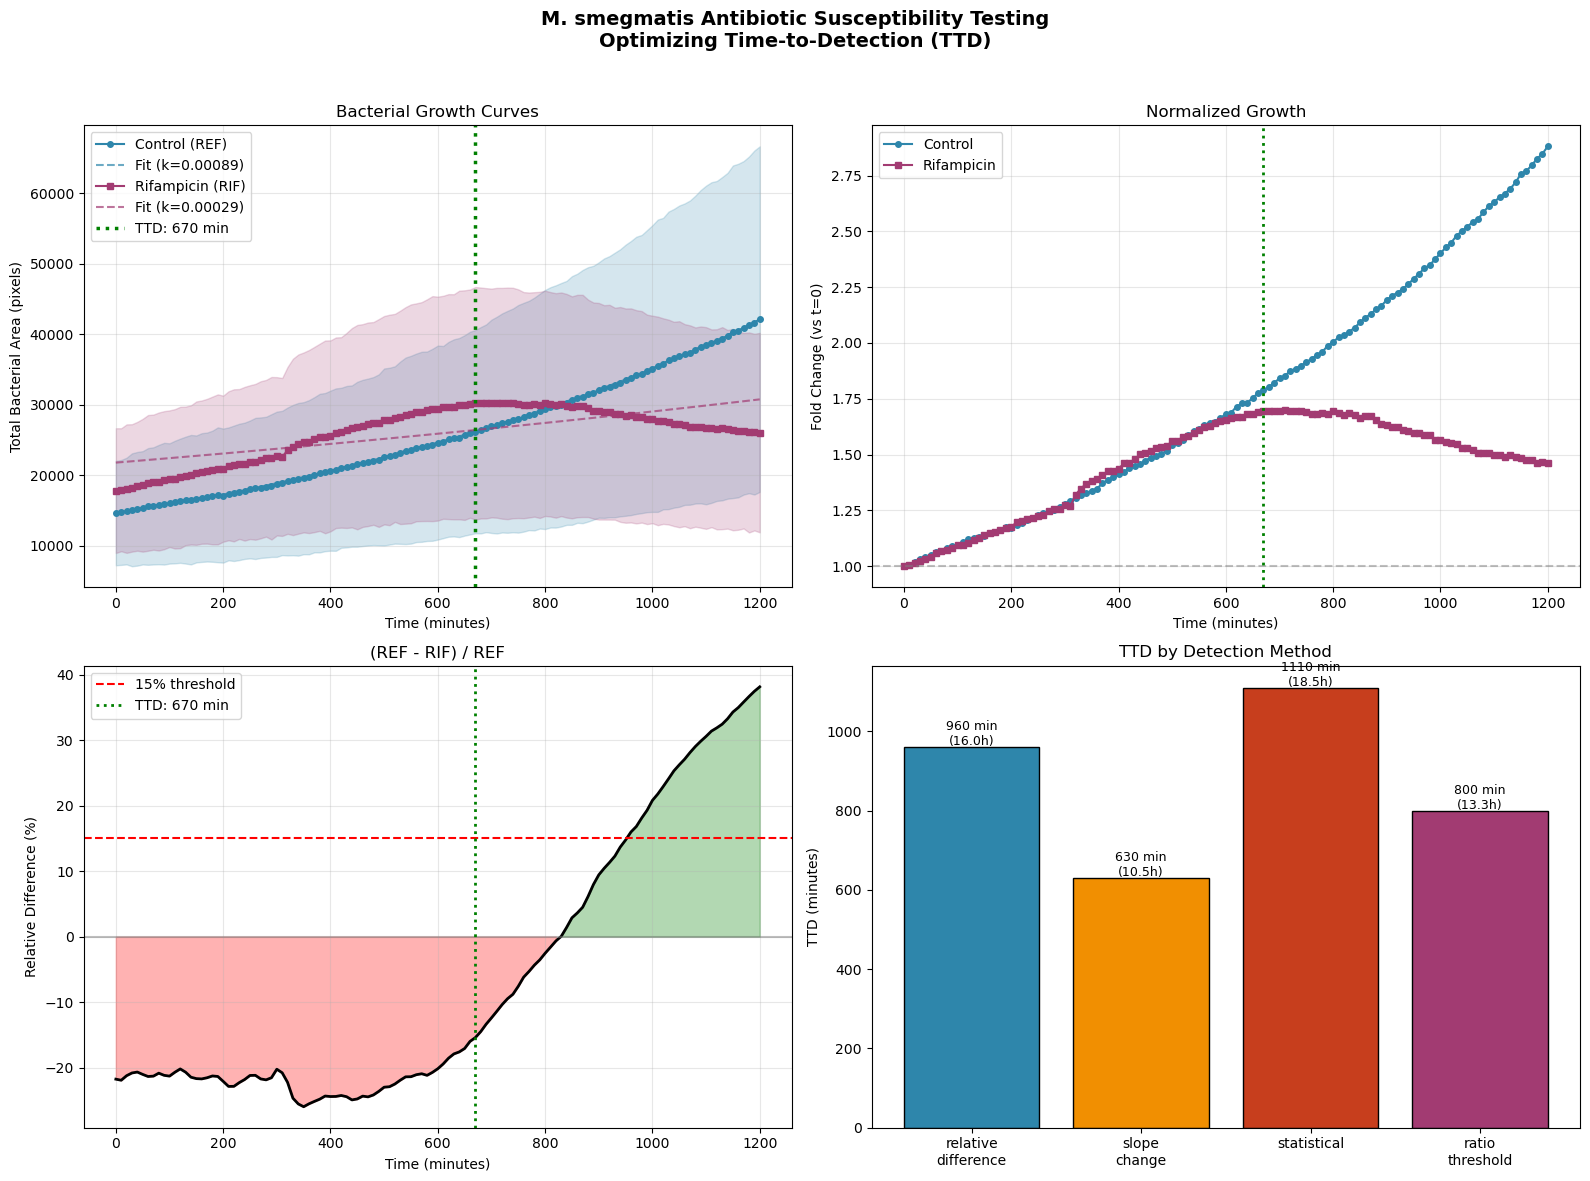


✓ Saved 'ttd_analysis_results.png'


In [22]:
# =============================================================================
# CELL 12: Main Visualization
# =============================================================================

# Get best TTD for visualization
best_ttd = opt_df.iloc[0]['ttd_min'] if len(opt_df) > 0 else None

fig = plt.figure(figsize=(16, 12))

# Plot 1: Growth curves with confidence bands
ax1 = fig.add_subplot(2, 2, 1)
if ref_times is not None:
    ax1.plot(ref_times, ref_mean, 'o-', color='#2E86AB', label='Control (REF)', markersize=4)
    if ref_std is not None:
        ax1.fill_between(ref_times, ref_mean - ref_std, ref_mean + ref_std, color='#2E86AB', alpha=0.2)
    if len(ref_fit) > 0:
        ax1.plot(ref_times, ref_fit, '--', color='#2E86AB', alpha=0.7, label=f'Fit (k={ref_k:.5f})')

if rif_times is not None:
    ax1.plot(rif_times, rif_mean, 's-', color='#A23B72', label='Rifampicin (RIF)', markersize=4)
    if rif_std is not None:
        ax1.fill_between(rif_times, rif_mean - rif_std, rif_mean + rif_std, color='#A23B72', alpha=0.2)
    if len(rif_fit) > 0:
        ax1.plot(rif_times, rif_fit, '--', color='#A23B72', alpha=0.7, label=f'Fit (k={rif_k:.5f})')

if best_ttd:
    ax1.axvline(best_ttd, color='green', linestyle=':', linewidth=2.5, label=f'TTD: {best_ttd:.0f} min')

ax1.set_xlabel('Time (minutes)')
ax1.set_ylabel('Total Bacterial Area (pixels)')
ax1.set_title('Bacterial Growth Curves')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Normalized growth
ax2 = fig.add_subplot(2, 2, 2)
if ref_mean is not None and rif_mean is not None:
    ref_norm = ref_mean / ref_mean[0]
    rif_norm = rif_mean / rif_mean[0]
    ax2.plot(ref_times, ref_norm, 'o-', color='#2E86AB', label='Control', markersize=4)
    ax2.plot(rif_times[:len(rif_norm)], rif_norm, 's-', color='#A23B72', label='Rifampicin', markersize=4)
    ax2.axhline(1.0, color='gray', linestyle='--', alpha=0.5)
    if best_ttd:
        ax2.axvline(best_ttd, color='green', linestyle=':', linewidth=2)

ax2.set_xlabel('Time (minutes)')
ax2.set_ylabel('Fold Change (vs t=0)')
ax2.set_title('Normalized Growth')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Relative difference over time
ax3 = fig.add_subplot(2, 2, 3)
if 'relative_difference' in ttd_results and 'rel_diff' in ttd_results['relative_difference']['info']:
    rel_diff = ttd_results['relative_difference']['info']['rel_diff']
    ax3.plot(ref_times[:len(rel_diff)], rel_diff * 100, 'k-', linewidth=2)
    ax3.axhline(15, color='red', linestyle='--', label='15% threshold')
    ax3.axhline(0, color='gray', linestyle='-', alpha=0.5)
    if best_ttd:
        ax3.axvline(best_ttd, color='green', linestyle=':', linewidth=2, label=f'TTD: {best_ttd:.0f} min')
    ax3.fill_between(ref_times[:len(rel_diff)], 0, rel_diff * 100, 
                     where=rel_diff > 0, color='green', alpha=0.3)
    ax3.fill_between(ref_times[:len(rel_diff)], 0, rel_diff * 100, 
                     where=rel_diff < 0, color='red', alpha=0.3)

ax3.set_xlabel('Time (minutes)')
ax3.set_ylabel('Relative Difference (%)')
ax3.set_title('(REF - RIF) / REF')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: TTD comparison across methods
ax4 = fig.add_subplot(2, 2, 4)
methods = []
ttd_values = []
colors = []
color_map = {'relative_difference': '#2E86AB', 'slope_change': '#F18F01', 
             'statistical': '#C73E1D', 'ratio_threshold': '#A23B72'}

for method, result in ttd_results.items():
    if result['ttd'] is not None:
        methods.append(method.replace('_', '\n'))
        ttd_values.append(result['ttd'])
        colors.append(color_map.get(method, 'gray'))

if ttd_values:
    bars = ax4.bar(methods, ttd_values, color=colors, edgecolor='black')
    for bar, val in zip(bars, ttd_values):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                 f'{val:.0f} min\n({val/60:.1f}h)', ha='center', fontsize=9)
    ax4.set_ylabel('TTD (minutes)')
    ax4.set_title('TTD by Detection Method')
else:
    ax4.text(0.5, 0.5, 'No TTD detected', ha='center', va='center', transform=ax4.transAxes)

plt.suptitle('M. smegmatis Antibiotic Susceptibility Testing\nOptimizing Time-to-Detection (TTD)', 
             fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('ttd_analysis_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Saved 'ttd_analysis_results.png'")

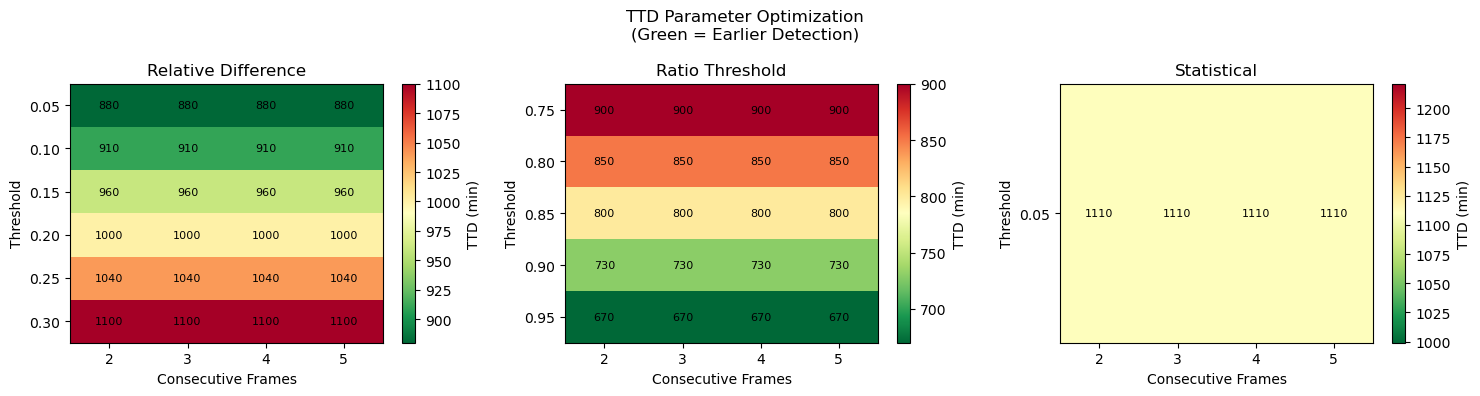

✓ Saved 'ttd_optimization_heatmap.png'


In [23]:
# =============================================================================
# CELL 13: TTD Optimization Heatmap
# =============================================================================

if len(opt_df) > 0:
    # Create pivot table for heatmap
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for idx, method in enumerate(['relative_difference', 'ratio_threshold', 'statistical']):
        method_df = opt_df[opt_df['method'] == method]
        if len(method_df) > 0:
            pivot = method_df.pivot_table(values='ttd_min', index='threshold', 
                                          columns='consecutive', aggfunc='first')
            if len(pivot) > 0:
                im = axes[idx].imshow(pivot.values, cmap='RdYlGn_r', aspect='auto')
                axes[idx].set_xticks(range(len(pivot.columns)))
                axes[idx].set_xticklabels(pivot.columns)
                axes[idx].set_yticks(range(len(pivot.index)))
                axes[idx].set_yticklabels([f'{x:.2f}' for x in pivot.index])
                axes[idx].set_xlabel('Consecutive Frames')
                axes[idx].set_ylabel('Threshold')
                axes[idx].set_title(method.replace('_', ' ').title())
                
                # Add text annotations
                for i in range(len(pivot.index)):
                    for j in range(len(pivot.columns)):
                        val = pivot.values[i, j]
                        if not np.isnan(val):
                            axes[idx].text(j, i, f'{val:.0f}', ha='center', va='center', fontsize=8)
                
                plt.colorbar(im, ax=axes[idx], label='TTD (min)')
    
    plt.suptitle('TTD Parameter Optimization\n(Green = Earlier Detection)', fontsize=12)
    plt.tight_layout()
    plt.savefig('ttd_optimization_heatmap.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ Saved 'ttd_optimization_heatmap.png'")
else:
    print("No optimization data to visualize")

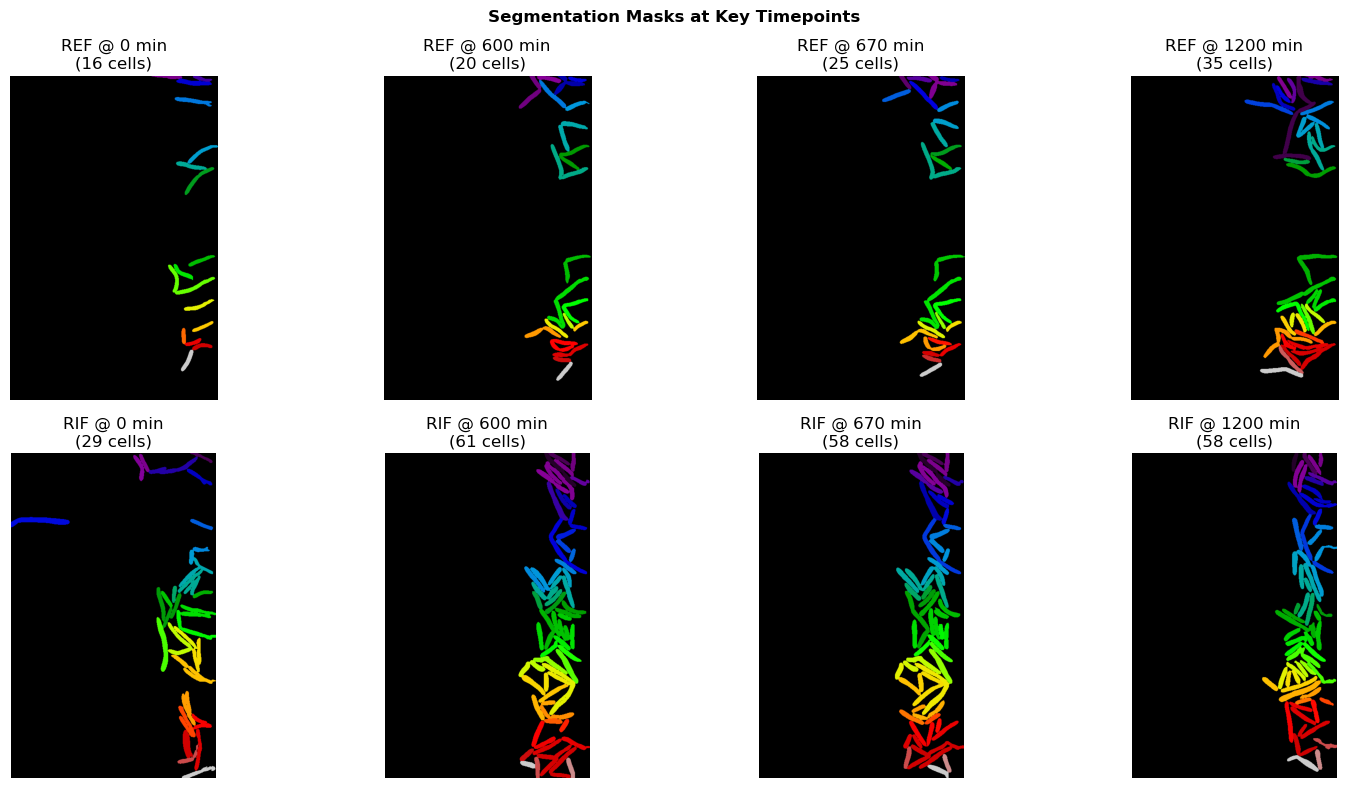

✓ Saved 'mask_comparison.png'


In [24]:
# =============================================================================
# CELL 14: Sample Mask Visualization
# =============================================================================

def show_masks_at_timepoints(ref_masks, rif_masks, timepoints_min, time_interval):
    """
    Show masks at specific timepoints for visual comparison.
    """
    n_times = len(timepoints_min)
    fig, axes = plt.subplots(2, n_times, figsize=(4*n_times, 8))
    
    for i, t_min in enumerate(timepoints_min):
        frame_idx = int(t_min / time_interval)
        
        # REF
        if frame_idx < len(ref_masks):
            mask = io.imread(ref_masks[frame_idx])
            axes[0, i].imshow(mask, cmap='nipy_spectral')
            n_cells = len(np.unique(mask)) - 1
            axes[0, i].set_title(f'REF @ {t_min} min\n({n_cells} cells)')
        axes[0, i].axis('off')
        
        # RIF
        if frame_idx < len(rif_masks):
            mask = io.imread(rif_masks[frame_idx])
            axes[1, i].imshow(mask, cmap='nipy_spectral')
            n_cells = len(np.unique(mask)) - 1
            axes[1, i].set_title(f'RIF @ {t_min} min\n({n_cells} cells)')
        axes[1, i].axis('off')
    
    axes[0, 0].set_ylabel('Control (REF)', fontsize=12)
    axes[1, 0].set_ylabel('Rifampicin (RIF)', fontsize=12)
    
    plt.suptitle('Segmentation Masks at Key Timepoints', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig('mask_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

# Re-fetch masks for the selected dataset for visualization
selected_dir = DATASET_DIRS[DATASET_INDEX] if DATASET_INDEX < len(DATASET_DIRS) else DATASET_DIRS[0]
if 'HR' in selected_dir.upper():
    all_masks = find_hr_masks(selected_dir)
else:
    all_masks = find_all_masks(selected_dir)

# Show masks at t=0, TTD, and end
if all_masks['REF'] and all_masks['RIF'] and ref_times is not None:
    max_time = ref_times[-1] if len(ref_times) > 0 else 100
    timepoints = [0]
    if best_ttd:
        timepoints.append(int(best_ttd))
    timepoints.append(int(max_time * 0.5))  # midpoint
    timepoints.append(int(max_time))  # end
    timepoints = sorted(set(timepoints))[:4]  # max 4 timepoints
    
    show_masks_at_timepoints(all_masks['REF'], all_masks['RIF'], timepoints, TIME_INTERVAL_MINUTES)
    print("✓ Saved 'mask_comparison.png'")

In [25]:
# =============================================================================
# CELL 15: Export Results
# =============================================================================

# Summary table
summary = {
    'Metric': [
        'REF Growth Rate (min⁻¹)',
        'RIF Growth Rate (min⁻¹)',
        'Growth Inhibition (%)',
        'REF R²',
        'RIF R²',
        'Best TTD (minutes)',
        'Best TTD (hours)',
        'Best TTD Method',
        'Number of REF positions',
        'Number of RIF positions',
        'Number of timepoints'
    ],
    'Value': [
        f'{ref_k:.6f}',
        f'{rif_k:.6f}',
        f'{inhibition:.1f}',
        f'{ref_r2:.4f}',
        f'{rif_r2:.4f}',
        f'{best_ttd:.0f}' if best_ttd else 'Not detected',
        f'{best_ttd/60:.2f}' if best_ttd else 'N/A',
        opt_df.iloc[0]['method'] if len(opt_df) > 0 else 'N/A',
        str(len(ref_data)),
        str(len(rif_data)),
        str(len(ref_times)) if ref_times is not None else '0'
    ]
}

summary_df = pd.DataFrame(summary)
summary_df.to_csv('analysis_summary.csv', index=False)

# Time series data
if ref_times is not None and rif_times is not None:
    min_len = min(len(ref_times), len(rif_times), len(ref_mean), len(rif_mean))
    ts_data = pd.DataFrame({
        'time_min': ref_times[:min_len],
        'time_hours': ref_times[:min_len] / 60,
        'REF_area_mean': ref_mean[:min_len],
        'REF_area_std': ref_std[:min_len] if ref_std is not None else 0,
        'RIF_area_mean': rif_mean[:min_len],
        'RIF_area_std': rif_std[:min_len] if rif_std is not None else 0,
    })
    ts_data.to_csv('growth_timeseries.csv', index=False)

# Optimization results
if len(opt_df) > 0:
    opt_df.to_csv('ttd_optimization_results.csv', index=False)

print("✓ Saved CSV files:")
print("  • analysis_summary.csv")
print("  • growth_timeseries.csv")
print("  • ttd_optimization_results.csv")

✓ Saved CSV files:
  • analysis_summary.csv
  • growth_timeseries.csv
  • ttd_optimization_results.csv


In [26]:
# =============================================================================
# CELL 16: Final Summary
# =============================================================================

for idx in range(len(all_ref_agg)):
    ref_times, ref_mean, ref_std, ref_curves = all_ref_agg[idx]
    rif_times, rif_mean, rif_std, rif_curves = all_rif_agg[idx]
    ref_k, ref_fit, ref_r2 = calculate_growth_rate(ref_times, ref_mean, f"REF (Dataset {idx+1})")
    rif_k, rif_fit, rif_r2 = calculate_growth_rate(rif_times, rif_mean, f"RIF (Dataset {idx+1})")
    inhibition = ((ref_k - rif_k) / ref_k) * 100 if ref_k > 0 else 0

    print("\n" + "="*70)
    print(f"                    ANALYSIS COMPLETE - FINAL SUMMARY (Dataset {idx+1})")
    print("="*70)
    print(f"\n📊 DATA PROCESSED")
    print(f"   Dataset: Dataset {idx+1}")
    print(f"   REF positions: {ref_curves.shape[0] if ref_curves is not None else 0}")
    print(f"   RIF positions: {rif_curves.shape[0] if rif_curves is not None else 0}")
    print(f"   Timepoints: {len(ref_times) if ref_times is not None else 0}")
    print(f"   Time interval: {TIME_INTERVAL_MINUTES} min/frame")
    print(f"\n📈 GROWTH ANALYSIS")
    print(f"   Control growth rate:    k = {ref_k:.6f} min⁻¹ (R² = {ref_r2:.3f})")
    print(f"   Rifampicin growth rate: k = {rif_k:.6f} min⁻¹ (R² = {rif_r2:.3f})")
    print(f"   Growth inhibition: {inhibition:.1f}%")
    print("="*70)






print(f"\n⏱️ TIME-TO-DETECTION (TTD) RESULTS")
if best_ttd:
    best_row = opt_df.iloc[0]
    print(f"   🏆 Best TTD: {best_ttd:.0f} minutes ({best_ttd/60:.2f} hours)")
    print(f"   Method: {best_row['method']}")
    print(f"   Parameters: threshold={best_row['threshold']}, consecutive={best_row['consecutive']}")
else:
    print("   ⚠️ TTD not detected with current parameters")

print(f"\n📁 OUTPUT FILES")
print(f"   • ttd_analysis_results.png - Main results figure")
print(f"   • ttd_optimization_heatmap.png - Parameter optimization")
print(f"   • mask_comparison.png - Visual mask comparison")
print(f"   • analysis_summary.csv - Summary statistics")
print(f"   • growth_timeseries.csv - Time series data")
print(f"   • ttd_optimization_results.csv - All TTD results")

print(f"\n✅ BIOLOGICAL VALIDATION")
if inhibition > 0 and best_ttd:
    print(f"   ✓ Rifampicin shows expected growth inhibition ({inhibition:.1f}%)")
    print(f"   ✓ Treatment effect detected at {best_ttd/60:.2f} hours")
    print(f"   → Results consistent with biological ground truth")
elif inhibition > 0:
    print(f"   ✓ Growth inhibition observed ({inhibition:.1f}%)")
    print(f"   ⚠️ TTD not detected - may need parameter adjustment")
else:
    print(f"   ⚠️ No clear inhibition observed - check data quality")

print("\n" + "="*70)
print("                         PIPELINE COMPLETE")
print("="*70)

REF (Dataset 1): k = 0.000887 min⁻¹, doubling time = 781.5 min, R² = 1.000
RIF (Dataset 1): k = 0.000287 min⁻¹, doubling time = 2412.3 min, R² = 0.509

                    ANALYSIS COMPLETE - FINAL SUMMARY (Dataset 1)

📊 DATA PROCESSED
   Dataset: Dataset 1
   REF positions: 10
   RIF positions: 20
   Timepoints: 121
   Time interval: 10 min/frame

📈 GROWTH ANALYSIS
   Control growth rate:    k = 0.000887 min⁻¹ (R² = 1.000)
   Rifampicin growth rate: k = 0.000287 min⁻¹ (R² = 0.509)
   Growth inhibition: 67.6%
REF (Dataset 2): k = -0.068380 min⁻¹, doubling time = -10.1 min, R² = 0.832
RIF (Dataset 2): k = -0.068034 min⁻¹, doubling time = -10.2 min, R² = 0.830

                    ANALYSIS COMPLETE - FINAL SUMMARY (Dataset 2)

📊 DATA PROCESSED
   Dataset: Dataset 2
   REF positions: 10
   RIF positions: 10
   Timepoints: 123
   Time interval: 10 min/frame

📈 GROWTH ANALYSIS
   Control growth rate:    k = -0.068380 min⁻¹ (R² = 0.832)
   Rifampicin growth rate: k = -0.068034 min⁻¹ (R² = 0.

Dataset 1 REF: k = 0.000887 min⁻¹, doubling time = 781.5 min, R² = 1.000
Dataset 1 RIF: k = 0.000287 min⁻¹, doubling time = 2412.3 min, R² = 0.509
Dataset 1 REF R²: 1.000
Dataset 1 RIF R²: 0.509

Dataset 1 - Final Growth Statistical Comparison
REF mean: 42121.7, RIF mean: 26028.7
t-test: t=1.83, p=9.21e-02
Mann-Whitney U: U=144.00, p=2.78e-02
Cohen's d: 0.77 (moderate)


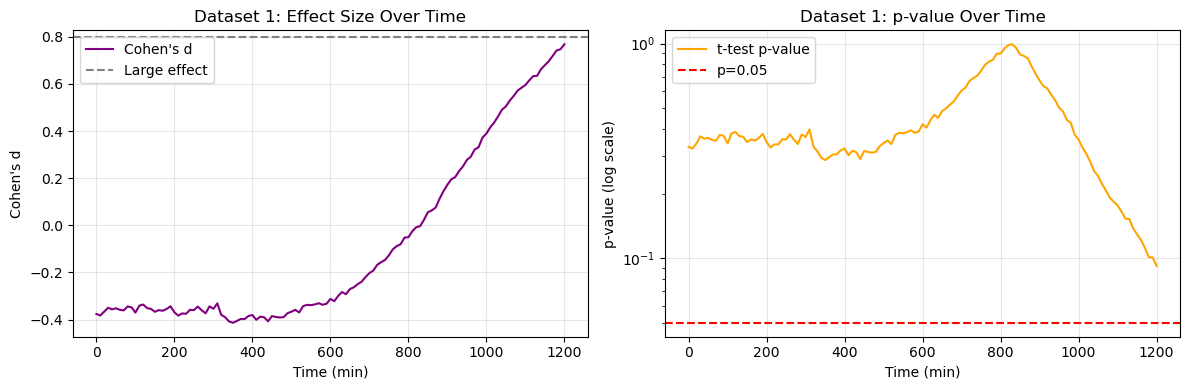

Dataset 2 REF: k = -0.068380 min⁻¹, doubling time = -10.1 min, R² = 0.832
Dataset 2 RIF: k = -0.068034 min⁻¹, doubling time = -10.2 min, R² = 0.830
Dataset 2 REF R²: 0.832
Dataset 2 RIF R²: 0.830

Dataset 2 - Final Growth Statistical Comparison
REF mean: 42121.7, RIF mean: 30324.5
t-test: t=1.31, p=2.12e-01
Mann-Whitney U: U=66.00, p=1.21e-01
Cohen's d: 0.59 (moderate)


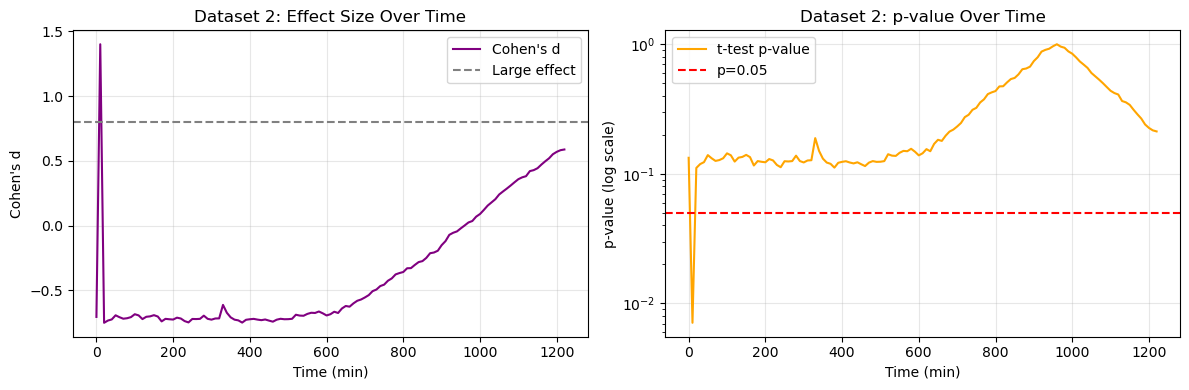

In [27]:

for i in range(len(all_ref_agg)):
    label = f"Dataset {i+1}"
    ref_times, ref_mean, ref_std, ref_curves = all_ref_agg[i]
    rif_times, rif_mean, rif_std, rif_curves = all_rif_agg[i]

    
    # Fit exponential model and print R² for both REF and RIF
    ref_k, ref_fit, ref_r2 = calculate_growth_rate(ref_times, ref_mean, f"{label} REF")
    rif_k, rif_fit, rif_r2 = calculate_growth_rate(rif_times, rif_mean, f"{label} RIF")
    print(f"{label} REF R²: {ref_r2:.3f}")
    print(f"{label} RIF R²: {rif_r2:.3f}")

    # Final timepoint values
    ref_final = ref_curves[:, -1]
    rif_final = rif_curves[:, -1]

    # t-test
    t_stat, t_p = ttest_ind(ref_final, rif_final, equal_var=False)
    # Mann-Whitney U
    u_stat, u_p = mannwhitneyu(ref_final, rif_final, alternative='greater')
    # Cohen's d
    pooled_std = np.sqrt((np.std(ref_final, ddof=1)**2 + np.std(rif_final, ddof=1)**2) / 2)
    cohend = (np.mean(ref_final) - np.mean(rif_final)) / pooled_std if pooled_std > 0 else np.nan

    print(f"\n{'='*60}\n{label} - Final Growth Statistical Comparison")
    print(f"REF mean: {np.mean(ref_final):.1f}, RIF mean: {np.mean(rif_final):.1f}")
    print(f"t-test: t={t_stat:.2f}, p={t_p:.2e}")
    print(f"Mann-Whitney U: U={u_stat:.2f}, p={u_p:.2e}")
    print(f"Cohen's d: {cohend:.2f} ({'large' if cohend > 0.8 else 'moderate' if cohend > 0.5 else 'small'})")

    # Time-resolved effect size and p-value
    effect_sizes = []
    pvals = []
    for t in range(ref_curves.shape[1]):
        ref_vals = ref_curves[:, t]
        rif_vals = rif_curves[:, t]
        pooled_std = np.sqrt((np.std(ref_vals, ddof=1)**2 + np.std(rif_vals, ddof=1)**2) / 2)
        d = (np.mean(ref_vals) - np.mean(rif_vals)) / pooled_std if pooled_std > 0 else np.nan
        effect_sizes.append(d)
        try:
            _, p = ttest_ind(ref_vals, rif_vals, equal_var=False)
        except:
            p = np.nan
        pvals.append(p)

    # Plot effect size and p-value over time
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(ref_times, effect_sizes, label="Cohen's d", color='purple')
    ax[0].axhline(0.8, color='gray', linestyle='--', label='Large effect')
    ax[0].set_title(f"{label}: Effect Size Over Time")
    ax[0].set_xlabel("Time (min)")
    ax[0].set_ylabel("Cohen's d")
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    ax[1].plot(ref_times, pvals, label="t-test p-value", color='orange')
    ax[1].axhline(0.05, color='red', linestyle='--', label='p=0.05')
    ax[1].set_yscale('log')
    ax[1].set_title(f"{label}: p-value Over Time")
    ax[1].set_xlabel("Time (min)")
    ax[1].set_ylabel("p-value (log scale)")
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import ttest_ind

# Ensure inline plotting for the notebook
%matplotlib inline

def analyze_and_report(ref_data_tuple, rif_data_tuple, dataset_name):
    """
    Comprehensive analysis pipeline for a single dataset with inline plotting.
    """
    print(f"\n{'='*80}")
    print(f"ANALYZING: {dataset_name}")
    print(f"{'='*80}\n")

    # Unpack data
    ref_times, ref_mean, ref_std, ref_curves = ref_data_tuple
    rif_times, rif_mean, rif_std, rif_curves = rif_data_tuple

    # --- 1. Data Health Check ---
    if ref_mean is None or len(ref_mean) < 5:
        print("❌ Error: Insufficient REF data.")
        return
    
    # Check for decreasing control (Invalid Experiment Warning)
    if ref_mean[-1] < ref_mean[0]:
        print("⚠️  WARNING: Control (REF) biomass decreased over time!")
        print("    This suggests a data quality issue (e.g., focus drift, cell loss, or bad segmentation).")
        print("    Growth rates derived from this dataset are likely invalid.\n")

    # --- 2. Robust Growth Rate (Log-Linear Method) ---
    def get_log_linear_rate(times, values):
        # Log-transform area to linearize exponential growth
        # Filter out zeros/NaNs to avoid log(0) errors
        valid = (values > 0) & (~np.isnan(values))
        if np.sum(valid) < 5:
            return 0, 0, np.zeros_like(times)
        
        t_clean = times[valid]
        y_clean = np.log(values[valid])
        
        # Linear Regression on Log Data
        slope, intercept, r_value, p_value, std_err = stats.linregress(t_clean, y_clean)
        
        # Calculate fitted curve back in normal scale for plotting
        fitted_curve = np.exp(intercept + slope * times)
        return slope, r_value**2, fitted_curve

    ref_k, ref_r2, ref_fit_curve = get_log_linear_rate(ref_times, ref_mean)
    rif_k, rif_r2, rif_fit_curve = get_log_linear_rate(rif_times, rif_mean)

    # Calculate Inhibition
    inhibition = 0
    if ref_k > 0:
        inhibition = ((ref_k - rif_k) / ref_k) * 100

    print(f"📈 Growth Kinetics (Log-Linear Model):")
    print(f"   REF Rate (k): {ref_k:.5f} min⁻¹ (R²={ref_r2:.3f})")
    print(f"   RIF Rate (k): {rif_k:.5f} min⁻¹ (R²={rif_r2:.3f})")
    print(f"   Inhibition:   {inhibition:.1f}%")
    
    if rif_r2 < 0.8:
        print(f"   ℹ️  Note: Low R² for RIF is expected as antibiotics disrupt exponential growth.")

    # --- 3. Time-to-Detection (TTD) - Ratio Method ---
    ttd_min = None
    ratio_threshold = 0.90 # 90% of initial ratio
    
    # Calculate normalized ratio curve
    min_len = min(len(ref_mean), len(rif_mean))
    raw_ratio = rif_mean[:min_len] / (ref_mean[:min_len] + 1e-9)
    norm_ratio = raw_ratio / raw_ratio[0] # Normalize to start at 1.0
    
    # Find point where ratio drops and stays below threshold
    for i, r in enumerate(norm_ratio):
        if i < len(norm_ratio)-3:
            if all(norm_ratio[i:i+3] < ratio_threshold):
                ttd_min = ref_times[i]
                break
    
    print(f"\n⏱️  Time-to-Detection (TTD):")
    if ttd_min:
        print(f"   Detected at: {ttd_min:.0f} min ({ttd_min/60:.1f} hours)")
    else:
        print(f"   Not detected (Curves did not diverge significantly)")

    # --- 4. Statistical Tests (End Point) ---
    ref_end = ref_curves[:, -1]
    rif_end = rif_curves[:, -1]
    # Remove NaNs
    ref_end = ref_end[~np.isnan(ref_end)]
    rif_end = rif_end[~np.isnan(rif_end)]
    
    t_stat, p_val = ttest_ind(ref_end, rif_end, equal_var=False)
    
    # Cohen's d (Effect Size)
    pooled_std = np.sqrt((np.std(ref_end, ddof=1)**2 + np.std(rif_end, ddof=1)**2) / 2)
    cohen_d = (np.mean(ref_end) - np.mean(rif_end)) / pooled_std
    
    print(f"\n📊 Statistical Comparison (End Point):")
    print(f"   P-value:     {p_val:.2e} {'(Significant)' if p_val < 0.05 else '(Not Significant)'}")
    print(f"   Effect Size: {cohen_d:.2f} (Cohen's d)")

    # --- 5. Visualization ---
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    
    # Plot A: Linear Growth
    ax[0].plot(ref_times, ref_mean, 'o', color='#2E86AB', alpha=0.3, label='REF Data')
    ax[0].plot(ref_times, ref_fit_curve, '-', color='#2E86AB', linewidth=2, label=f'REF Fit')
    ax[0].plot(rif_times, rif_mean, 's', color='#A23B72', alpha=0.3, label='RIF Data')
    ax[0].plot(rif_times, rif_fit_curve, '-', color='#A23B72', linewidth=2, label=f'RIF Fit')
    ax[0].set_title(f"{dataset_name}: Linear Growth")
    ax[0].set_xlabel("Time (min)")
    ax[0].set_ylabel("Total Area (pixels)")
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    # Plot B: Log Scale (Linearizes Exponential Growth)
    # Mask zeros for log plot
    ref_mask = ref_mean > 0
    rif_mask = rif_mean > 0
    ax[1].plot(ref_times[ref_mask], np.log(ref_mean[ref_mask]), '-', color='#2E86AB', label=f'REF (k={ref_k:.4f})')
    ax[1].plot(rif_times[rif_mask], np.log(rif_mean[rif_mask]), '-', color='#A23B72', label=f'RIF (k={rif_k:.4f})')
    if ttd_min:
        ax[1].axvline(ttd_min, color='green', linestyle='--', label=f'TTD')
    ax[1].set_title(f"{dataset_name}: Log Scale Growth")
    ax[1].set_xlabel("Time (min)")
    ax[1].set_ylabel("ln(Area)")
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)

    # Plot C: Normalized Ratio
    ax[2].plot(ref_times[:len(norm_ratio)], norm_ratio, color='purple', linewidth=2, label='RIF/REF Ratio')
    ax[2].axhline(ratio_threshold, color='orange', linestyle='--', label=f'Threshold ({ratio_threshold})')
    if ttd_min:
        ax[2].axvline(ttd_min, color='green', linestyle='--', label='TTD')
        ax[2].plot(ttd_min, ratio_threshold, 'g*', markersize=15)
    ax[2].set_title(f"{dataset_name}: Normalized Ratio")
    ax[2].set_xlabel("Time (min)")
    ax[2].set_ylabel("Ratio (RIF / REF)")
    ax[2].set_ylim(0, 1.2)
    ax[2].legend()
    ax[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


ANALYZING: Susceptible Strain (Original)

📈 Growth Kinetics (Log-Linear Model):
   REF Rate (k): 0.00088 min⁻¹ (R²=1.000)
   RIF Rate (k): 0.00034 min⁻¹ (R²=0.572)
   Inhibition:   61.2%
   ℹ️  Note: Lower R² for RIF (0.572) is expected/good. It confirms the antibiotic disrupted exponential growth.

⏱️  Time-to-Detection (TTD):
   Detected at: 730 min (12.2 hours)

📊 Statistical Comparison (End Point):
   P-value:     9.21e-02 (Not Significant)
   Effect Size: 0.77 (Cohen's d)


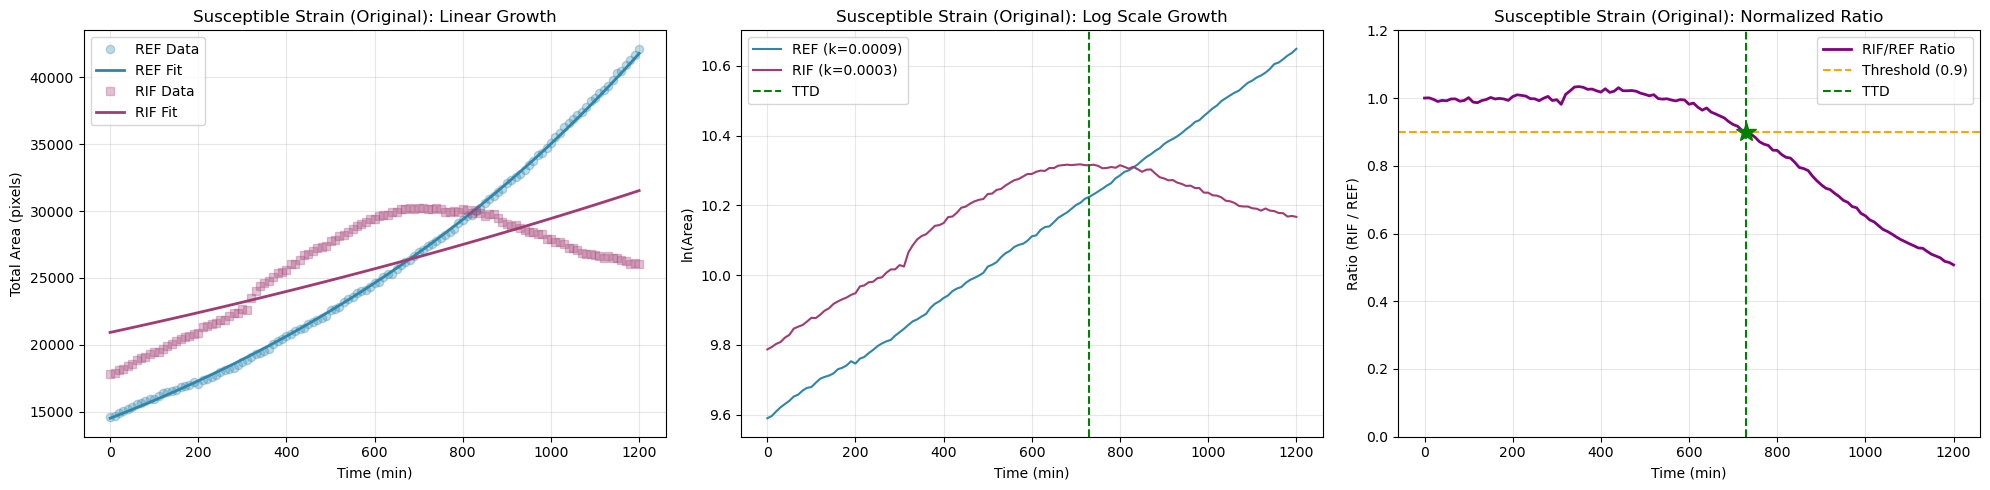


ANALYZING: Heteroresistant Strain (HR)

⚠️  WARNING: Control (REF) biomass decreased over time!
    This suggests a data quality issue (e.g., focus drift, cell loss, or bad segmentation).
    Growth rates derived from this dataset are likely invalid.

📈 Growth Kinetics (Log-Linear Model):
   REF Rate (k): 0.00049 min⁻¹ (R²=0.073)
   RIF Rate (k): 0.00001 min⁻¹ (R²=0.000)
   Inhibition:   97.5%
   ℹ️  Note: Lower R² for RIF (0.000) is expected/good. It confirms the antibiotic disrupted exponential growth.

⏱️  Time-to-Detection (TTD):
   Detected at: 1040 min (17.3 hours)

📊 Statistical Comparison (End Point):
   P-value:     2.12e-01 (Not Significant)
   Effect Size: 0.59 (Cohen's d)


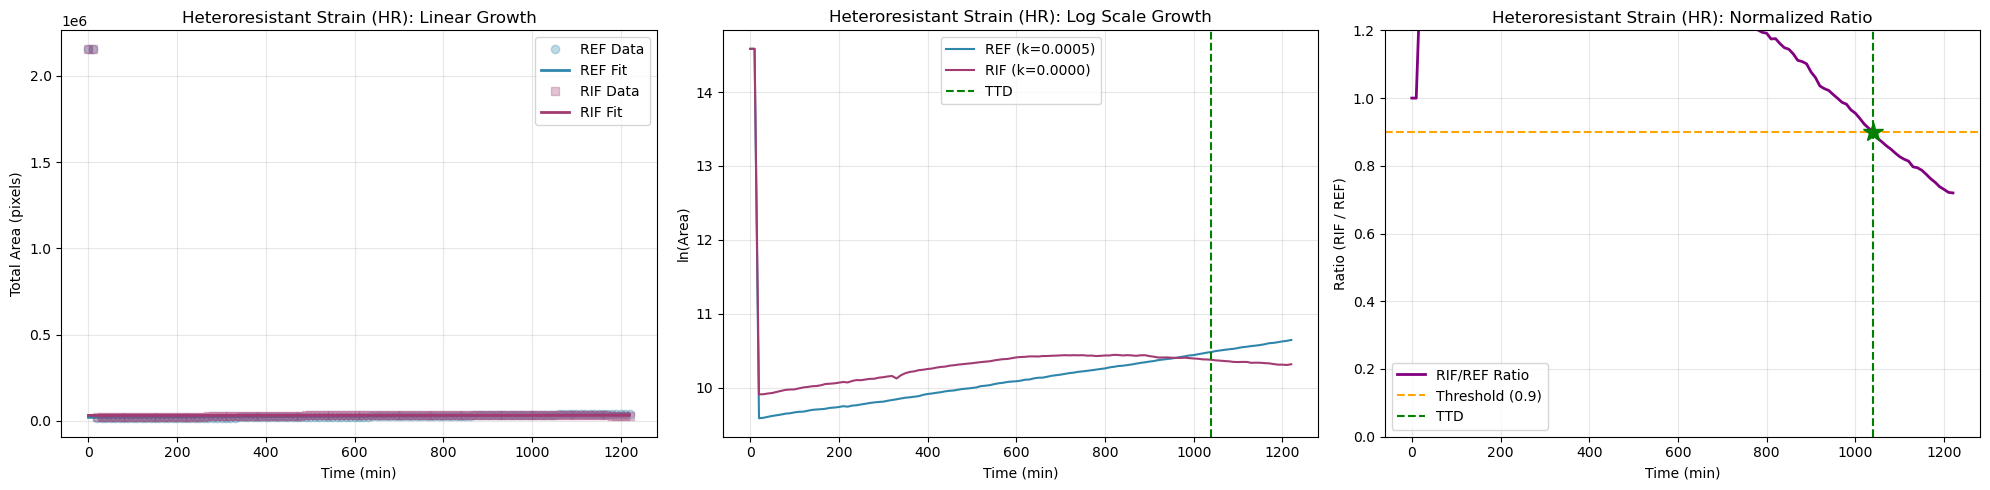

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import ttest_ind

# Ensure inline plotting for the notebook
%matplotlib inline

def analyze_and_report(ref_data_tuple, rif_data_tuple, dataset_name):
    """
    Comprehensive analysis pipeline for a single dataset with inline plotting.
    Handles both exponential growth (Control) and inhibition (Treated) robustly.
    """
    print(f"\n{'='*80}")
    print(f"ANALYZING: {dataset_name}")
    print(f"{'='*80}\n")

    # Unpack data
    ref_times, ref_mean, ref_std, ref_curves = ref_data_tuple
    rif_times, rif_mean, rif_std, rif_curves = rif_data_tuple

    # --- 1. Data Health Check ---
    if ref_mean is None or len(ref_mean) < 5:
        print("❌ Error: Insufficient REF data.")
        return
    
    # Check for decreasing control (Invalid Experiment Warning)
    # If control is shrinking, it implies focus drift or cells washing away
    if ref_mean[-1] < ref_mean[0]:
        print("⚠️  WARNING: Control (REF) biomass decreased over time!")
        print("    This suggests a data quality issue (e.g., focus drift, cell loss, or bad segmentation).")
        print("    Growth rates derived from this dataset are likely invalid.\n")

    # --- 2. Robust Growth Rate (Log-Linear Method) ---
    def get_log_linear_rate(times, values):
        # Log-transform area to linearize exponential growth: ln(y) = kt + ln(A0)
        # Filter out zeros/NaNs to avoid log(0) errors
        valid = (values > 0) & (~np.isnan(values))
        if np.sum(valid) < 5:
            return 0, 0, np.zeros_like(times)
        
        t_clean = times[valid]
        y_clean = np.log(values[valid])
        
        # Linear Regression on Log Data
        slope, intercept, r_value, p_value, std_err = stats.linregress(t_clean, y_clean)
        
        # Calculate fitted curve back in normal scale for plotting
        fitted_curve = np.exp(intercept + slope * times)
        return slope, r_value**2, fitted_curve

    ref_k, ref_r2, ref_fit_curve = get_log_linear_rate(ref_times, ref_mean)
    rif_k, rif_r2, rif_fit_curve = get_log_linear_rate(rif_times, rif_mean)

    # Calculate Inhibition
    inhibition = 0
    if ref_k > 0:
        inhibition = ((ref_k - rif_k) / ref_k) * 100

    print(f"📈 Growth Kinetics (Log-Linear Model):")
    print(f"   REF Rate (k): {ref_k:.5f} min⁻¹ (R²={ref_r2:.3f})")
    print(f"   RIF Rate (k): {rif_k:.5f} min⁻¹ (R²={rif_r2:.3f})")
    print(f"   Inhibition:   {inhibition:.1f}%")
    
    if rif_r2 < 0.8:
        print(f"   ℹ️  Note: Lower R² for RIF ({rif_r2:.3f}) is expected/good. It confirms the antibiotic disrupted exponential growth.")

    # --- 3. Time-to-Detection (TTD) - Ratio Method ---
    ttd_min = None
    ratio_threshold = 0.90 # 90% of initial ratio
    
    # Calculate normalized ratio curve
    min_len = min(len(ref_mean), len(rif_mean))
    raw_ratio = rif_mean[:min_len] / (ref_mean[:min_len] + 1e-9)
    norm_ratio = raw_ratio / raw_ratio[0] # Normalize to start at 1.0
    
    # Find point where ratio drops and stays below threshold
    for i, r in enumerate(norm_ratio):
        if i < len(norm_ratio)-3:
            if all(norm_ratio[i:i+3] < ratio_threshold):
                ttd_min = ref_times[i]
                break
    
    print(f"\n⏱️  Time-to-Detection (TTD):")
    if ttd_min:
        print(f"   Detected at: {ttd_min:.0f} min ({ttd_min/60:.1f} hours)")
    else:
        print(f"   Not detected (Curves did not diverge significantly)")

    # --- 4. Statistical Tests (End Point) ---
    ref_end = ref_curves[:, -1]
    rif_end = rif_curves[:, -1]
    # Remove NaNs
    ref_end = ref_end[~np.isnan(ref_end)]
    rif_end = rif_end[~np.isnan(rif_end)]
    
    t_stat, p_val = ttest_ind(ref_end, rif_end, equal_var=False)
    
    # Cohen's d (Effect Size)
    pooled_std = np.sqrt((np.std(ref_end, ddof=1)**2 + np.std(rif_end, ddof=1)**2) / 2)
    cohen_d = (np.mean(ref_end) - np.mean(rif_end)) / pooled_std
    
    print(f"\n📊 Statistical Comparison (End Point):")
    print(f"   P-value:     {p_val:.2e} {'(Significant)' if p_val < 0.05 else '(Not Significant)'}")
    print(f"   Effect Size: {cohen_d:.2f} (Cohen's d)")

    # --- 5. Visualization ---
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    
    # Plot A: Linear Growth
    ax[0].plot(ref_times, ref_mean, 'o', color='#2E86AB', alpha=0.3, label='REF Data')
    ax[0].plot(ref_times, ref_fit_curve, '-', color='#2E86AB', linewidth=2, label=f'REF Fit')
    ax[0].plot(rif_times, rif_mean, 's', color='#A23B72', alpha=0.3, label='RIF Data')
    ax[0].plot(rif_times, rif_fit_curve, '-', color='#A23B72', linewidth=2, label=f'RIF Fit')
    ax[0].set_title(f"{dataset_name}: Linear Growth")
    ax[0].set_xlabel("Time (min)")
    ax[0].set_ylabel("Total Area (pixels)")
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    # Plot B: Log Scale (Linearizes Exponential Growth)
    # Mask zeros for log plot
    ref_mask = ref_mean > 0
    rif_mask = rif_mean > 0
    ax[1].plot(ref_times[ref_mask], np.log(ref_mean[ref_mask]), '-', color='#2E86AB', label=f'REF (k={ref_k:.4f})')
    ax[1].plot(rif_times[rif_mask], np.log(rif_mean[rif_mask]), '-', color='#A23B72', label=f'RIF (k={rif_k:.4f})')
    if ttd_min:
        ax[1].axvline(ttd_min, color='green', linestyle='--', label=f'TTD')
    ax[1].set_title(f"{dataset_name}: Log Scale Growth")
    ax[1].set_xlabel("Time (min)")
    ax[1].set_ylabel("ln(Area)")
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)

    # Plot C: Normalized Ratio
    ax[2].plot(ref_times[:len(norm_ratio)], norm_ratio, color='purple', linewidth=2, label='RIF/REF Ratio')
    ax[2].axhline(ratio_threshold, color='orange', linestyle='--', label=f'Threshold ({ratio_threshold})')
    if ttd_min:
        ax[2].axvline(ttd_min, color='green', linestyle='--', label='TTD')
        ax[2].plot(ttd_min, ratio_threshold, 'g*', markersize=15)
    ax[2].set_title(f"{dataset_name}: Normalized Ratio")
    ax[2].set_xlabel("Time (min)")
    ax[2].set_ylabel("Ratio (RIF / REF)")
    ax[2].set_ylim(0, 1.2)
    ax[2].legend()
    ax[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# =========================================================
# RUN ANALYSIS FOR ALL DATASETS
# =========================================================

for i in range(len(all_ref_agg)):
    # Name datasets based on index
    name = "Susceptible Strain (Original)" if i == 0 else "Heteroresistant Strain (HR)"
    
    # Run analysis function
    analyze_and_report(all_ref_agg[i], all_rif_agg[i], name)